In [ ]:
!pip install transformers matplotlib datasets peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which i

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


roberta.embeddings.LayerNorm.bias is trainable
roberta.encoder.layer.0.attention.self.query.bias is trainable
roberta.encoder.layer.0.attention.self.key.bias is trainable
roberta.encoder.layer.0.attention.self.value.bias is trainable
roberta.encoder.layer.0.attention.output.dense.bias is trainable
roberta.encoder.layer.0.attention.output.LayerNorm.bias is trainable
roberta.encoder.layer.0.intermediate.dense.bias is trainable
roberta.encoder.layer.0.output.dense.bias is trainable
roberta.encoder.layer.0.output.LayerNorm.bias is trainable
roberta.encoder.layer.1.attention.self.query.bias is trainable
roberta.encoder.layer.1.attention.self.key.bias is trainable
roberta.encoder.layer.1.attention.self.value.bias is trainable
roberta.encoder.layer.1.attention.output.dense.bias is trainable
roberta.encoder.layer.1.attention.output.LayerNorm.bias is trainable
roberta.encoder.layer.1.intermediate.dense.bias is trainable
roberta.encoder.layer.1.output.dense.bias is trainable
roberta.encoder.laye

Epoch,Training Loss,Validation Loss,Accuracy
1,0.686700,0.695060,0.509174
2,0.670600,0.668456,0.516055
3,0.565800,0.525682,0.847477


Epoch 1.0 - Train Accuracy: 0.5468, Eval Accuracy: 0.5092
Epoch 2.0 - Train Accuracy: 0.5498, Eval Accuracy: 0.5161
Epoch 3.0 - Train Accuracy: 0.8456, Eval Accuracy: 0.8475


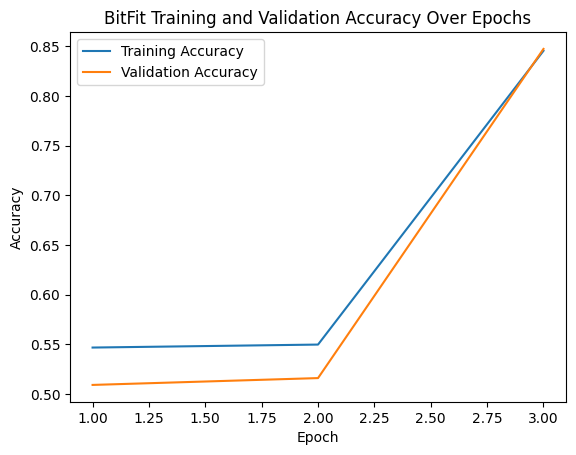

Test Accuracy: 0.8474770642201835


In [ ]:
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, load_metric
import numpy as np
import torch
from transformers.trainer_callback import TrainerCallback
import matplotlib.pyplot as plt

# Load the SST-2 dataset
dataset = load_dataset("glue", "sst2")

# Tokenizer and preprocessing
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def preprocess_function(examples):
    return tokenizer(examples['sentence'], truncation=True, padding=True)

encoded_dataset = dataset.map(preprocess_function, batched=True)

# Optional: Reduce the dataset size to speed up training
small_train = encoded_dataset['train'].shuffle(seed=42).select([i for i in range(5000)])  # Change this value for faster training
small_eval = encoded_dataset['validation'].shuffle(seed=42).select([i for i in range(872)])

# Load the RoBERTa model for sequence classification
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Freeze all parameters except the biases
for name, param in model.named_parameters():
    if 'bias' not in name:
        param.requires_grad = False

# Check trainable parameters (for debugging)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} is trainable")

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",               # Output directory
    eval_strategy="epoch",                # Evaluate at the end of every epoch
    save_strategy="epoch",                # Save at the end of every epoch
    num_train_epochs=3,                   # Total number of epochs to train for
    per_device_train_batch_size=8,        # Smaller batch size for training
    per_device_eval_batch_size=8,         # Smaller batch size for evaluation
    weight_decay=0.01,                    # Regularization
    load_best_model_at_end=True,          # Load the best model at the end of training
    save_total_limit=2,                   # Limit the number of saved checkpoints
    fp16=True,                            # Mixed precision for faster training (if supported by GPU)
    logging_dir="./logs",                 # Directory for logging
    logging_steps=100                     # Log every 100 steps
)

# Function to compute accuracy
def compute_metrics(pred):
    logits = pred.predictions
    labels = pred.label_ids
    preds = np.argmax(logits, axis=1)
    accuracy = np.mean(preds == labels)
    return {'accuracy': accuracy}

# Create a custom callback to store accuracy for each epoch
class AccuracyCallback(TrainerCallback):
    def __init__(self):
        self.train_accuracies = []
        self.eval_accuracies = []

    def on_epoch_end(self, args, state, control, **kwargs):
        train_result = trainer.predict(small_train)
        train_acc = compute_metrics(train_result)['accuracy']
        eval_result = trainer.evaluate()
        eval_acc = eval_result['eval_accuracy']

        self.train_accuracies.append(train_acc)
        self.eval_accuracies.append(eval_acc)

        print(f"Epoch {state.epoch} - Train Accuracy: {train_acc:.4f}, Eval Accuracy: {eval_acc:.4f}")

# Initialize the callback
accuracy_callback = AccuracyCallback()

# Initialize the Trainer with the LoRA model
trainer = Trainer(
    model=model,                         # The Bitfit model to train
    args=training_args,                  # Training arguments defined above
    train_dataset=small_train,           # Reduced training set
    eval_dataset=small_eval,             # Reduced validation set
    tokenizer=tokenizer,
    compute_metrics=lambda p:{'accuracy': np.mean(np.argmax(p.predictions, axis=1) == p.label_ids)},     # Compute accuracy
    callbacks=[accuracy_callback]        # Pass the custom callback
)

# Train the model (this will train for all epochs and log accuracy per epoch)
trainer.train()

# Plot the accuracies over epochs
epochs = list(range(1, training_args.num_train_epochs + 1))
plt.plot(epochs, accuracy_callback.train_accuracies, label="Training Accuracy")
plt.plot(epochs, accuracy_callback.eval_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("BitFit Training and Validation Accuracy Over Epochs")
plt.legend()
plt.savefig("bitfit_accuracy_over_epochs.png")
plt.show()

# Test set evaluation
test_result = trainer.predict(encoded_dataset['validation'])
test_acc = np.mean(np.argmax(test_result.predictions, axis=1) == test_result.label_ids)
print(f"Test Accuracy: {test_acc}")